In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


# ML Models
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


# Default theme
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif',
font_scale=1, color_codes=False, rc=None)

# Handling warnings
warnings.filterwarnings('ignore')

# Paths to datasets
import os
os.chdir('/content/drive/MyDrive/Machine Learning Notebooks/Datasets/loan prediction problem')
print(os.getcwd())

/content/drive/MyDrive/Machine Learning Notebooks/Datasets/loan prediction problem


In [2]:
# Loading of Data and SUmmary statistics
train_df = pd.read_csv('loan pred train.csv')
test_df = pd.read_csv('loan pred test.csv')

#train_df.head(10)
train_df.info(verbose=True, null_counts=True)
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [3]:
train_df.head(8)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N


In [3]:
# ID Column is not needed, so we drop it
train_df.drop('Loan_ID', axis=1, inplace=True)
test_df.drop('Loan_ID', axis=1, inplace=True)

train_df.Dependents.replace('3+', 3, inplace=True)
test_df.Dependents.replace('3+', 3, inplace=True)

In [4]:
# Checking missing values in descending order

null_cols = train_df.isnull().sum().sort_values(ascending=False).index.to_list()
print(null_cols)

['Credit_History', 'Self_Employed', 'LoanAmount', 'Dependents', 'Loan_Amount_Term', 'Gender', 'Married', 'Loan_Status', 'Property_Area', 'CoapplicantIncome', 'ApplicantIncome', 'Education']


In [5]:
# We will replace null values with the mode of the null columns

for col in null_cols:
    # print(f'{col}:\n{train_df[col].value_counts()}\n', '-'*50)
    train_df[col] = train_df[col].fillna(train_df[col].mode().values[0])

train_df.isnull().sum().sort_values(ascending=False)

Loan_Status          0
Property_Area        0
Credit_History       0
Loan_Amount_Term     0
LoanAmount           0
CoapplicantIncome    0
ApplicantIncome      0
Self_Employed        0
Education            0
Dependents           0
Married              0
Gender               0
dtype: int64

**Data Visualisation**

We first split our data to categorical and numerical data

In [6]:
# List of all numeric and categorical columns 

nums = train_df.select_dtypes('number').columns.to_list()
cats = train_df.select_dtypes('object').columns.to_list()

loan_nums = train_df[nums]
loan_cats = train_df[cats]

Y    422
N    192
Name: Loan_Status, dtype: int64


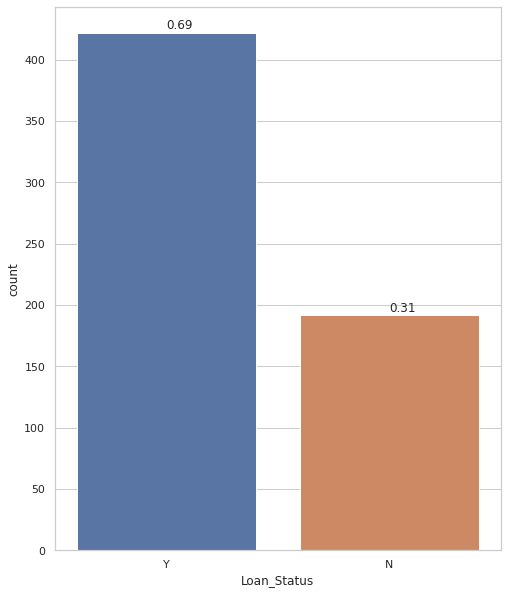

In [10]:
# Check distribution of loan_status column and visualise
print(train_df[cats[-1]].value_counts())

total = float(len(train_df[cats[-1]]))
plt.figure(figsize=(8, 10))
sns.set(style='whitegrid')
ax = sns.countplot(train_df[cats[-1]]) # Plot a barplot of the number of values of each category

for p in ax.patches:
    # Adding the percentage values on the barplots
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 3, '{:1.2f}'.format(height/total, ha = 'center'))
plt.show() # Plot of loan_status categorical column

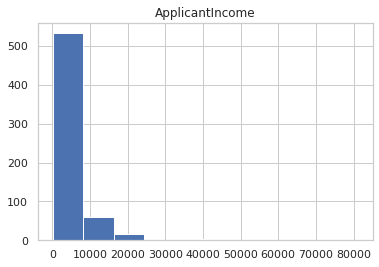

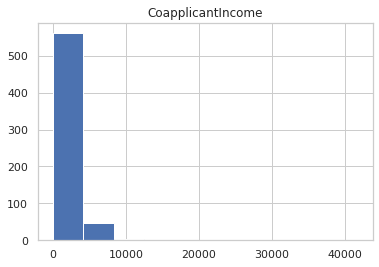

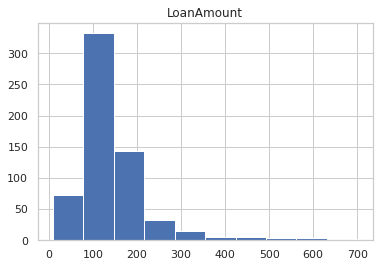

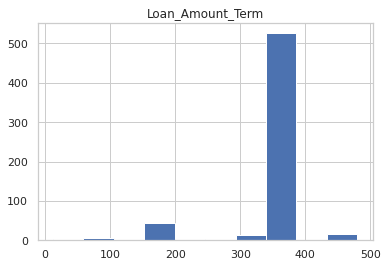

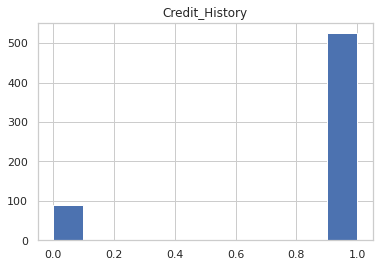

In [ ]:
for i in loan_nums:
    plt.hist(loan_nums[i])
    plt.title(i)
    plt.show()

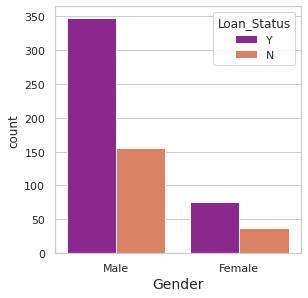

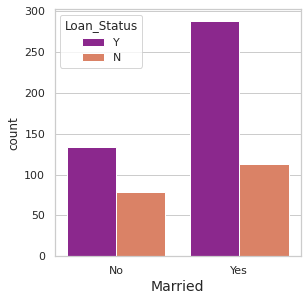

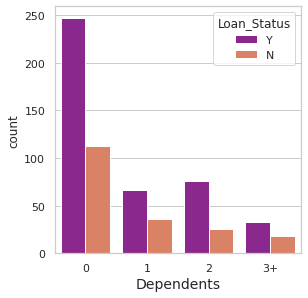

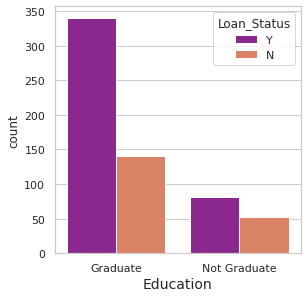

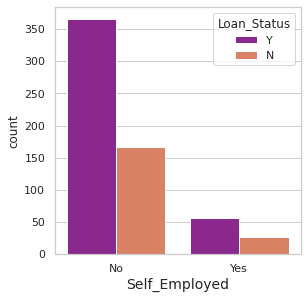

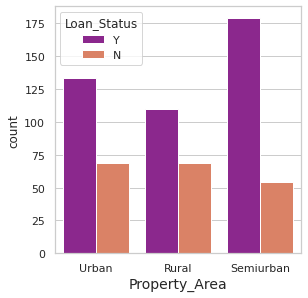

In [ ]:
# Distribution of the categorical classes according the loan status

for i in cats[:-1]:
    plt.figure(figsize=(15,10))
    plt.subplot(2, 3, 1)
    sns.countplot(x = i, hue='Loan_Status',data=train_df, palette='plasma')
    plt.xlabel(i, fontsize=14)

Encoding Cateogircal Data to Numeric Values

In [11]:
train_df[cats].shape

(614, 7)

In [8]:
'''
to_numeric = {'Male': 1, 'Female': 2,
'Yes': 1, 'No': 2,
'Graduate': 1, 'Not Graduate': 2,
'Urban': 3, 'Semiurban': 2,'Rural': 1,
'Y': 1, 'N': 0,
'3+':3}

train_df = train_df.applymap(lambda label: to_numeric.get(label) if label in to_numeric else label)
test_df = test_df.applymap(lambda label: to_numeric.get(label) if label in to_numeric else label)


# Converting the Dependants Column
Dependants_ = pd.to_numeric(train_df.Dependents)
Dependants__ = pd.to_numeric(test_df.Dependents)

# Dropping previous dependants column
train_df.drop(['Dependents'], axis = 1, inplace=True)
test_df.drop(['Dependents'], axis = 1, inplace=True)

# Concatinating new dependants columns to original datasets
train_df = pd.Concat([train_df, Dependats_], axis = 1)
test_df = pd.Concat([train_df, Dependats__], axis = 1)

print(train_df.shape)
print(train_df.info())
'''

#converting categorical values to numbers

to_numeric = {'Male': 1, 'Female': 2,
'Yes': 1, 'No': 2,
'Graduate': 1, 'Not Graduate': 2,
'Urban': 3, 'Semiurban': 2,'Rural': 1,
'Y': 1, 'N': 0,
'3+': 3}

# adding the new numeric values from the to_numeric variable to both datasets
train_df = train_df.applymap(lambda label: to_numeric.get(label) if label in to_numeric else label)
test_df = test_df.applymap(lambda label: to_numeric.get(label) if label in to_numeric else label)

# convertind the Dependents column
Dependents_ = pd.to_numeric(train_df.Dependents)
Dependents__ = pd.to_numeric(test_df.Dependents)

# dropping the previous Dependents column
train_df.drop(['Dependents'], axis = 1, inplace = True)
test_df.drop(['Dependents'], axis = 1, inplace = True)

# concatination of the new Dependents column with both datasets
train_df = pd.concat([train_df, Dependents_], axis = 1)
test_df = pd.concat([test_df, Dependents__], axis = 1)

# checking the our manipulated dataset for validation
print(f"training set (row, col): {train_df.shape}\n\ntesting set (row, col): {test_df.shape}\n")
print(train_df.info(), "\n\n", test_df.info())

training set (row, col): (614, 12)

testing set (row, col): (367, 11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    int64  
 1   Married            614 non-null    int64  
 2   Education          614 non-null    int64  
 3   Self_Employed      614 non-null    int64  
 4   ApplicantIncome    614 non-null    int64  
 5   CoapplicantIncome  614 non-null    float64
 6   LoanAmount         614 non-null    float64
 7   Loan_Amount_Term   614 non-null    float64
 8   Credit_History     614 non-null    float64
 9   Property_Area      614 non-null    int64  
 10  Loan_Status        614 non-null    int64  
 11  Dependents         614 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 57.7 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 11 column

In [26]:
from sklearn.preprocessing import OneHotEncoder
def label_encode(dFrame, category):
    le = LabelEncoder()
    dFrame[category] = le.fit_transform(dFrame[category])
    return dFrame

def onehot_encoder(dFrame, category):
    onee = OneHotEncoder()
    dFrame[category] = onee.fit_transform(dFrame[category])
    return dFrame.to_array()

# for i in range(len(cats[:-1])):
a = label_encode(train_df, cats[0])
onehot_encoder(a, cats[0])

ValueError: ignored

In [7]:
train_df.tail(5)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
609,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,Male,Yes,3,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y
613,Female,No,0,Graduate,Yes,4583,0.0,133.0,360.0,0.0,Semiurban,N


**Correlation Matrix**

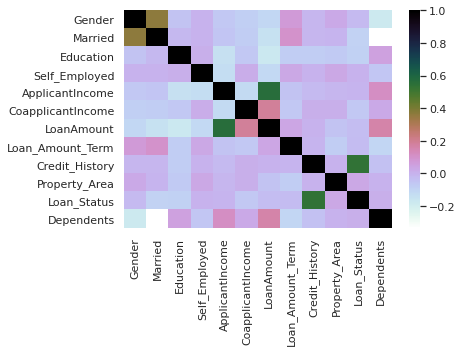

In [10]:
sns.heatmap(train_df.corr(), cmap='cubehelix_r')

In [11]:
corr = train_df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Dependents
Gender,1.00,0.36,-0.05,-0.00,-0.06,-0.08,-0.11,0.07,-0.01,0.03,-0.02,-0.17
Married,0.36,1.00,-0.01,0.00,-0.05,-0.08,-0.15,0.10,-0.01,-0.00,-0.09,-0.33
Education,-0.05,-0.01,1.00,0.01,-0.14,-0.06,-0.17,-0.07,-0.07,-0.07,-0.09,0.06
Self_Employed,-0.00,0.00,0.01,1.00,-0.13,0.02,-0.11,0.03,0.00,0.03,0.00,-0.06
ApplicantIncome,-0.06,-0.05,-0.14,-0.13,1.00,-0.12,0.56,-0.05,-0.02,-0.01,-0.00,0.12
CoapplicantIncome,-0.08,-0.08,-0.06,0.02,-0.12,1.00,0.19,-0.06,0.01,0.01,-0.06,0.03
LoanAmount,-0.11,-0.15,-0.17,-0.11,0.56,0.19,1.00,0.04,-0.00,-0.05,-0.03,0.16
Loan_Amount_Term,0.07,0.10,-0.07,0.03,-0.05,-0.06,0.04,1.00,-0.00,-0.08,-0.02,-0.10
Credit_History,-0.01,-0.01,-0.07,0.00,-0.02,0.01,-0.00,-0.00,1.00,0.00,0.54,-0.04
Property_Area,0.03,-0.00,-0.07,0.03,-0.01,0.01,-0.05,-0.08,0.00,1.00,0.03,-0.00


we can see that the Loan Status is highly correlated to the Credit History column. This means that the target value is highly correlated to this column.

**Training of Models**

Models used:


*   Decision Trees
*   Random Forest
*   XGBoost
*   Logistic Regression

In [8]:
y = train_df['Loan_Status']
X = train_df.drop('Loan_Status', axis=1)

X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [12]:
X_train.head(3)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_3,Dependents_0,Dependents_1,Dependents_2,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
351,8750,4167.0,308.0,360.0,1.0,0,1,1,0,0,1,0,0,1,0,1,0,1,0,0
593,3859,3300.0,142.0,180.0,1.0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0
320,2400,2167.0,115.0,360.0,1.0,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0


**Decision Tree Model**

In [10]:
# Confusion Matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

tree = DecisionTreeClassifier(max_depth=1)

y_train_preds = cross_val_predict(tree, X_train, y_train, cv=3)
confusion_matrix(y_train, y_train_preds)

array([[ 61,  80],
       [  5, 283]])

In [13]:
# Cross Validation Scoring
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree, X_train, y_train, cv = 3, scoring='accuracy')

print(f'{scores}\nAverage Scores: {round(sum(scores)/len(scores)*100, 2)}')

[0.81818182 0.78321678 0.8041958 ]
Average Scores: 80.19


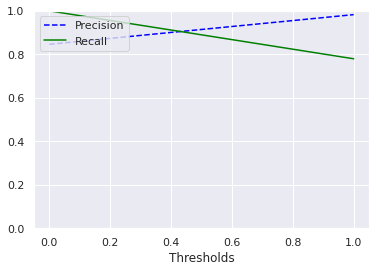

In [28]:
# Plot of Precision vs Recall
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_preds, y_train)

def plot_precision_vs_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Thresholds')
    plt.legend(loc = 'upper left')
    plt.ylim([0,1])

plot_precision_vs_recall(precisions, recalls, thresholds)
plt.show()

In [14]:
tree.fit(X_train, y_train)

y_predictions = tree.predict(X_test)

# Prediction Summary
print(classification_report(y_test, y_predictions))

#Accuracy Score
tree_score = accuracy_score(y_test, y_predictions)

print(f"{round(tree_score*100, 2)}% Accurate")

              precision    recall  f1-score   support

           N       0.91      0.41      0.57        51
           Y       0.81      0.99      0.89       134

    accuracy                           0.83       185
   macro avg       0.86      0.70      0.73       185
weighted avg       0.84      0.83      0.80       185

82.7% Accurate


**Random Forest Classifier**

In [15]:
from sklearn.metrics import plot_confusion_matrix
random_forest = RandomForestClassifier(n_estimators=500,max_leaf_nodes=16,n_jobs=-1)
random_forest.fit(X_train, y_train)

y_forest_preds = cross_val_predict(random_forest, X_train, y_train, cv = 3)

confusion_matrix(y_train, y_forest_preds)

array([[ 61,  80],
       [  6, 282]])

In [16]:
y_forest_pred_true = random_forest.predict(X_test)

print(classification_report(y_test, y_forest_pred_true))
print(f"{round(accuracy_score(y_test, y_forest_pred_true)*100,2)}%")

              precision    recall  f1-score   support

           N       0.88      0.41      0.56        51
           Y       0.81      0.98      0.89       134

    accuracy                           0.82       185
   macro avg       0.84      0.69      0.72       185
weighted avg       0.83      0.82      0.80       185

82.16%


**Logistic Regression Classifier**

In [17]:
log_regressor = LogisticRegression()

log_regressor.fit(X_train, y_train)

y_log_reg_preds = log_regressor.predict(X_test)

print(classification_report(y_test, y_log_reg_preds))

print(f'{round(accuracy_score(y_test, y_log_reg_preds)*100,2)}%')

              precision    recall  f1-score   support

           N       0.92      0.43      0.59        51
           Y       0.82      0.99      0.89       134

    accuracy                           0.83       185
   macro avg       0.87      0.71      0.74       185
weighted avg       0.85      0.83      0.81       185

83.24%
